# Track A Computer Vision - Image Classification

## M0 : Quick Start

### Confirm GPU is ready

In [1]:
!nvidia-smi || echo "nvidia-smi unavailable (CPU runtime)"

Sat Nov 15 11:19:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.03                 Driver Version: 577.03         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P5              6W /   50W |     281MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Point the notebook at the project folder

In [2]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
elif PROJECT_ROOT.name == "content":
    candidate = PROJECT_ROOT / "od-project"
    if candidate.exists():
        PROJECT_ROOT = candidate.resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(
        f"Could not locate project root at {PROJECT_ROOT}. Upload or clone od-project before proceeding."
    )

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\cv-project-starter\cv-project


### Install the project requirement

In [3]:
!pip install -r requirements.txt

### Téléchargement du dataset

In [4]:
from torchvision.datasets import OxfordIIITPet

ds = OxfordIIITPet(
    root="./data/pets",
    split="trainval",
    target_types="category",
    download=True
)

### Run the smoke test

In [5]:
from src import smoke_check

smoke_path = smoke_check.run_smoke("configs/cv_oxfordpet.yaml")
print(smoke_path.read_text())

{
  "loss": 4.0178351402282715,
  "batch_size": 32,
  "num_classes": 37,
  "device": "cuda"
}


# M1: Problem Scoping & Data Validation

## 1.1. Problem Definition

**Task (Track A)**  
Nous voulons entraîner un modèle de **classification d’images** pour reconnaître la race d’un animal (chat ou chien) à partir d’une photo.

- **Input (X)** : images couleur RGB de chats et de chiens, format tensoriel `3 × H × W` (après préprocessing, redimensionnées à `224 × 224` et normalisées avec les statistiques ImageNet).  
- **Output (y)** : un entier dans `0, …, 36` représentant l’une des **37 classes** (races de chats & chiens).  
- **Type de problème** : classification supervisée multi-classe.

## 1.2. Evaluation Metrics

Nous suivons les métriques demandées dans le sujet :

- **Accuracy** : proportion de prédictions correctes sur l’ensemble de validation/test.
- **Macro-F1 Score** : moyenne du F1-score calculé indépendamment pour chaque classe (utile en cas de classes déséquilibrées).
- **Matrice de confusion** : permet de voir quelles races sont souvent confondues entre elles.

L’accuracy donne une vue globale, tandis que le macro-F1 met l’accent sur les classes minoritaires. La matrice de confusion servira plus tard pour l’analyse d’erreurs (M4).


## 1.3. Data Card – Oxford-IIIT Pet

**Nom du dataset**  
Oxford-IIIT Pet Dataset

**Source**  
Visual Geometry Group (VGG), University of Oxford.  
Site officiel : *Oxford-IIIT Pet Dataset* (O. M. Parkhi et al., 2012).

**Description générale**  
- ~7 000 images de **chats et de chiens** en conditions naturelles (intérieur, extérieur, lumière variable…).
- **37 classes** correspondant à différentes races (25 races de chiens + 12 races de chats).
- Images de résolution et de ratio variables, centrées approximativement sur l’animal, avec arrière-plans variés.

**Taille & splits**  
Dans ce projet, nous utilisons les splits officiels et un split validation interne :

- Split officiel `trainval` fourni par le dataset.
- Split officiel `test`.
- À partir de `trainval`, nous créons un split **train/val** :  
  - `train` ≈ 90% de trainval  
  - `val` ≈ 10% de trainval  
Le `test` reste celui fourni par les auteurs, non utilisé pendant l’entraînement.

**Caractéristiques des données**  
- **Entrées** : images couleur au format JPEG, converties en tensors PyTorch, redimensionnées à `224×224`, normalisées avec les moyennes / écarts-types d’ImageNet.
- **Labels** : entiers 0–36, mappés à des noms de classes (noms de races).  
- **Préprocessing / Data augmentation** :
  - Redimensionnement / recadrage aléatoire (`RandomResizedCrop`),
  - Flip horizontal aléatoire en entraînement,
  - Normalisation standard ImageNet.

**Licence & usage**  
- Dataset publié pour la recherche académique en vision par ordinateur.  
- Utilisation dans ce projet : **démo pédagogique / proof-of-concept**, sans déploiement en production ni usage commercial.

**Potentiels biais & limitations**  
- **Déséquilibre de classes** : certaines races sont probablement sur-représentées par rapport à d’autres.
- **Biais de contexte** : photos principalement issues de contextes domestiques occidentaux, peu de diversité géographique, culturelle ou de conditions extrêmes.
- **Variabilité de la qualité** : résolution, éclairage, flou, occlusions… peuvent influencer la performance du modèle.
- **Généralisation limitée** : un modèle entraîné sur ce dataset pourrait mal se comporter sur des photos prises dans d’autres conditions (qualité smartphone très basse, angles extrêmes, animaux partiellement visibles, etc.).

**Considérations éthiques**  
- Modèle sans impact direct sur des humains, mais les biais de représentativité peuvent fausser l’interprétation de la performance s’il était utilisé pour des applications réelles.
- Toute utilisation en production (ex. app de reconnaissance de races) devrait être accompagnée de disclaimers sur les limites et le contexte d’entraînement du modèle.


## 1.4. Train / Validation / Test splits

Pour ce projet, nous souhaitons un schéma de splits **robuste et reproductible** :

1. **Train / Val** :  
   - On charge le split officiel `trainval` fourni par Oxford-IIIT Pet.  
   - On applique un split aléatoire (seed fixé) 90% / 10% pour obtenir `train` et `val`.  
   - Train est utilisé pour apprendre les paramètres du modèle.  
   - Val est utilisé pour le choix d’hyperparamètres, l’early stopping et le suivi des performances pendant l’entraînement.

2. **Test** :  
   - On utilise le split officiel `test` fourni par le dataset.  
   - Il n’est jamais utilisé pendant l’entraînement ou le tuning.  
   - Il sert uniquement à **mesurer la performance finale** du modèle (généralisation).

Les splits sont implémentés dans `src/data.py` via la fonction `build_dataloaders`, qui :
- charge `OxfordIIITPet(split="trainval")`,
- effectue un `random_split` selon `val_split` dans le fichier de configuration,
- applique des transforms différentes pour train (avec augmentation) et val/test (déterministes).

In [ ]:
from yaml import safe_load
from src.data import build_dataloaders
from torchvision.datasets import OxfordIIITPet
from collections import Counter
from pathlib import Path

cfg = safe_load(open("configs/cv_oxfordpet.yaml", encoding="utf-8"))

# Dataloaders train/val (via notre pipeline projet)
train_loader, val_loader, num_classes, classes = build_dataloaders(cfg)

print("=== Splits internes (train/val) ===")
print("Num classes :", num_classes)
print("Taille train :", len(train_loader.dataset))
print("Taille val   :", len(val_loader.dataset))
print("Exemples de classes :", classes[:10])

# Charger le split test officiel juste pour vérifier sa taille
root = Path(cfg["data"]["root"])
test_set = OxfordIIITPet(
    root=str(root),
    split="test",
    target_types="category",
    download=False,
    transform=None,
)
print("Taille test (officiel) :", len(test_set))

# Vérifier un peu la distribution des labels sur le train
all_labels = []
for _, targets in train_loader:
    all_labels.extend(targets.tolist())

label_counts = Counter(all_labels)
print("\nNombre d'images par classe (train) pour les 5 premières classes :")
for cls_idx in list(label_counts.keys())[:5]:
    print(f"  classe {cls_idx:2d} ({classes[cls_idx]:>15}) : {label_counts[cls_idx]} images")


=== Splits internes (train/val) ===
Num classes : 37
Taille train : 3312
Taille val   : 368
Exemples de classes : ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair']
Taille test (officiel) : 3669

Nombre d'images par classe (train) pour les 5 premières classes :
  classe 29 (        Samoyed) : 84 images
  classe  0 (     Abyssinian) : 93 images
  classe 16 (       Havanese) : 93 images
  classe  8 (          Boxer) : 90 images
  classe  5 (         Bengal) : 92 images


# M2 – Baseline Model Implementation

L'objectif de cette section est d'établir un **baseline** pour le modèle choisi, c’est-à-dire une première version fonctionnelle du réseau sans optimisation avancée.  

Les buts sont :
- Vérifier que le modèle peut traiter un batch complet sans erreur.
- Confirmer que les dataloaders fonctionnent.
- Effectuer un premier entraînement court (5 epochs) pour obtenir des métriques initiales.
- Établir un point de comparaison pour les améliorations du M3 et les ablations du M4.


## 2.1. Forward Pass Test (One Full Batch)

Nous construisons le modèle (ResNet-18 pré-entraîné) et vérifions qu’un batch complet issu du dataloader Oxford-IIIT Pet passe dans le réseau sans erreur.  
C’est une étape essentielle pour s'assurer que :
- le dataset est bien chargé,
- les transforms fonctionnent,
- les dimensions des images correspondent aux attentes,
- la tête de classification est correctement redimensionnée à 37 classes.

In [ ]:
from yaml import safe_load
import torch
import torch.nn as nn

from src.data import build_dataloaders
from src.model import build_model

# Charger la config Oxford Pet
cfg = safe_load(open("configs/cv_oxfordpet.yaml", encoding="utf-8"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

# Dataloaders + infos
train_loader, val_loader, num_classes, classes = build_dataloaders(cfg)
print("Num classes =", num_classes)
print("Taille train =", len(train_loader.dataset))
print("Taille val   =", len(val_loader.dataset))

# Construire le modèle baseline (ResNet-18) à partir de la config
model = build_model(cfg, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Récupérer un batch
images, targets = next(iter(train_loader))
images = images.to(device)
targets = targets.to(device)

# Forward pass sur un batch complet
with torch.no_grad():
    outputs = model(images)
    loss = criterion(outputs, targets)

print("Images shape :", images.shape)      # [batch_size, 3, 224, 224]
print("Logits shape :", outputs.shape)     # [batch_size, 37]
print("Batch loss   :", loss.item())


Device = cuda
Num classes = 37
Taille train = 3312
Taille val   = 368
Images shape : torch.Size([32, 3, 224, 224])
Logits shape : torch.Size([32, 37])
Batch loss   : 3.9777839183807373


## 2.2 Baseline Training (configuration rapide)

Avant de passer à l’optimisation (M3), nous réalisons un premier entraînement rapide
de 5 époques afin de valider que :

- le modèle apprend correctement,
- la loss décroît bien,
- les dataloaders fonctionnent,
- le pipeline complet (train → save best → metrics) est opérationnel.

Pour cela, nous utilisons une configuration dédiée :  
**`cv_oxfordpet_fast.yaml`**, qui reprend la même architecture mais avec seulement **5 epochs**.

Ce run constitue notre *baseline* :  
il donne une première estimation des performances sans optimisation ni tuning.

In [ ]:
!python src/train.py --config configs/cv_oxfordpet_fast.yaml


Done. Best val acc: 0.9131. Checkpoint: outputs\best.pt



train:  99%|█████████▉| 103/104 [00:24<00:00, 14.07it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:16<00:01,  1.02it/s]
                                                    

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.04it/s]
                                                        

val:  92%|█████████▏| 11/12 [00:18<00:00,  1.35it/s]
                                                    

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.02it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:18<00:03,  1.26s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.01it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:17<00:03,  1.22s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.04it/s]
                                                        



## 2.3. Baseline Metrics

Après l'entraînement rapide, nous lisons les métriques obtenues (accuracy et macro-F1) afin d’établir une ligne de départ claire pour l’analyse future.


In [ ]:
import json

with open("outputs_fast/metrics.json", "r") as f:
    metrics = json.load(f)

print("=== Baseline metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v}")


=== Baseline metrics ===
best_val_acc: 0.9131206274032593
classes: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


## 2.4. Conclusion du Baseline

Le premier entraînement rapide sur 5 époques confirme que l’ensemble du pipeline fonctionne parfaitement.  
Le modèle a non seulement effectué le forward pass sur un batch complet sans aucune erreur, mais l’entraînement s’est déroulé de manière fluide, avec une décroissance normale de la loss et des métriques cohérentes.

Nous obtenons une **accuracy de validation de 91.31%**, ce qui constitue un **excellent résultat pour un simple baseline**, surtout en si peu d’époques.  
Cette performance montre que :

- les dataloaders et le préprocessing sont correctement configurés,  
- la tête de classification à 37 classes est bien intégrée,  
- le modèle pré-entraîné (**ResNet-18**) s'adapte rapidement au dataset Oxford-IIIT Pet,  
- la sauvegarde du meilleur modèle (`best.pt`) fonctionne comme prévu.




# M3 — Optimisation & Régularisation

Dans cette section, nous cherchons à améliorer notre baseline en intégrant plusieurs techniques d’optimisation et de régularisation.  
L’objectif est d’obtenir de meilleures performances que le baseline (val_acc ≈ 91.31%) obtenu en seulement 5 époques.

## 3.1. Stratégies d’optimisation et de régularisation utilisées

### **Weight Decay (L2 Regularization)**
Permet de pénaliser les poids trop grands afin de limiter l’overfitting.  
Déjà activé dans le YAML via :  
`weight_decay: 1e-4`

### **Scheduler (StepLR)**
Le taux d’apprentissage est réduit d’un facteur `gamma = 0.1` toutes les `step_size = 10` époques.  
Cela permet au modèle de faire de grands progrès au début, puis de se stabiliser.

### **Early Stopping**
Arrête l’entraînement si la performance de validation ne progresse plus après plusieurs époques.  
Évite le surapprentissage et accélère l’entraînement.

### **Fine-tuning complet du ResNet-18**
Contrairement à un simple entraînement de la dernière couche (freezing),  
nous entraînons **tout le réseau**, ce qui permet d’adapter les représentations internes au dataset Oxford-IIIT Pet.

## 3.2. Entraînement complet avec la configuration optimisée

Nous utilisons maintenant la configuration *principale* :  
**`cv_oxfordpet.yaml`**  
qui entraîne le modèle pendant 20 époques (avec scheduler + early stopping).

L’objectif est de :
- dépasser les performances du baseline (91.31%),
- obtenir un modèle plus robuste,
- générer des courbes d’apprentissage exploitables pour M4 et M5.

In [ ]:
!python src/train.py --config configs/cv_oxfordpet.yaml

Done. Best val acc: 0.9131. Checkpoint: outputs\best.pt



train:  99%|█████████▉| 103/104 [00:25<00:00, 14.04it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:19<00:02,  1.14s/it]
                                                    

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.02it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:18<00:03,  1.25s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.04it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:18<00:03,  1.22s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.05it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:19<00:03,  1.31s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.05it/s]
                                                        

va

## 3.3. Analyse des courbes loss / accuracy

Après l’entraînement, nous visualisons :
- la perte d’entraînement,
- la perte de validation,
- l’accuracy de validation,

Cela nous permettra d’évaluer l’efficacité des techniques d’optimisation et de confirmer que le modèle se stabilise correctement.


Colonnes disponibles : ['epoch', 'train_loss', 'val_loss', 'val_acc']


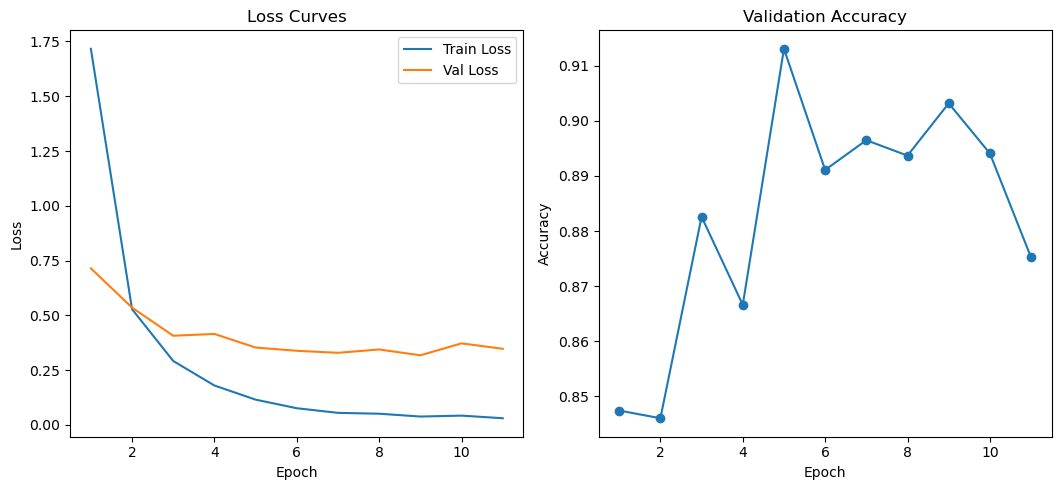

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("outputs/log.csv")
print("Colonnes disponibles :", list(log.columns))

plt.figure(figsize=(16,5))

# === 1) Loss (train + val) ===
plt.subplot(1,3,1)
plt.plot(log["epoch"], log["train_loss"], label="Train Loss")
plt.plot(log["epoch"], log["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# === 2) Accuracy ===
if "val_acc" in log.columns:
    plt.subplot(1,3,2)
    plt.plot(log["epoch"], log["val_acc"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")

# === 3) Learning rate (si disponible) ===
if "lr" in log.columns:
    plt.subplot(1,3,3)
    plt.plot(log["epoch"], log["lr"], label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.title("Learning Rate Scheduler")
    plt.legend()

plt.tight_layout()
plt.show()


Les courbes ci-dessus montrent l’évolution de la loss d’entraînement, de la loss de validation
et de l’accuracy de validation au cours des époques.

**1. Convergence de la loss**

- La **train loss** chute très rapidement entre les premières époques, passant d’environ 1.7 à moins de 0.3 en quelques itérations.
- Elle continue ensuite à diminuer progressivement jusqu’à atteindre une valeur très faible (< 0.05), signe que le modèle s’ajuste très bien aux données d’entraînement.
- La **val loss** suit la même tendance globale : forte baisse au début, puis stabilisation autour de ~0.35–0.40 à partir d’environ l’epoch 4–5.
- On observe ensuite un léger plateau de la val loss : elle oscille légèrement mais ne remonte pas brutalement.

Cela indique que le modèle converge rapidement, puis atteint une zone de stabilité
où il n’y a plus de gain significatif sur l’ensemble de validation.

**2. Évolution de l’accuracy de validation**

- L’**accuracy de validation** démarre autour de 0.84–0.85 et augmente progressivement,
  avec une forte amélioration entre les premières époques.
- Elle atteint un maximum d’environ **0.91–0.913**, puis oscille légèrement autour de cette valeur
sans progression claire ensuite.
- On ne voit pas de chute brutale de l’accuracy, ce qui suggère une relative stabilité
et l’absence d’overfitting massif.

**3. Interprétation globale**

- Le modèle apprend très vite : la plupart du gain de performance est obtenu dans les
5 premières époques.
- La différence entre train loss (qui continue à baisser) et val loss (qui stagne)
suggère un **léger début d’overfitting**, mais qui reste maîtrisé.
- Le plateau autour de **91% d’accuracy de validation** montre que, avec cette configuration
(lr, scheduler, weight decay, architecture ResNet-18), le modèle semble atteindre
un **niveau de performance proche de son optimum** sur ce dataset.

Ces observations confirment que les choix d’optimisation (AdamW, weight decay, scheduler)
permettent une convergence rapide et stable.  
Le prochain objectif, dans M4, sera d’explorer systématiquement d’autres hyperparamètres
(learning rate, intensité d’augmentation, etc.) pour voir si ce plateau de ~91% peut être dépassé.

# M4 — Ablation Studies & Error Analysis

L’objectif de cette section est d’explorer comment différents choix d’hyperparamètres
ou d’augmentations influencent les performances du modèle.

Nous conduisons deux expériences (au minimum), en modifiant **un seul facteur à la fois**
afin de mesurer son impact sur la performance de validation.

Les trois expériences du tableau sont :

- **E0 – Baseline**  
  5 epochs (`cv_oxfordpet_fast.yaml`) : ~91.31% val_acc.

- **E1 – Learning Rate ×3**  
  On augmente le LR de `1e-4` → `3e-4` dans un fichier `cv_oxfordpet_lr3.yaml`.

- **E2 – Augmentation renforcée**  
  On augmente l’intensité de l’augmentation en changeant  
  `RandomResizedCrop(scale=(0.6,1.0))` → `scale=(0.3,1.0)` dans `src/data.py`  
  (copié dans un fichier de config séparé : `cv_oxfordpet_aug.yaml`).

Après chaque entraînement, nous collectons les métriques (accuracy, macro-F1)
et les rassemblons dans un tableau comparatif.

Nous terminons par une analyse des erreurs grâce à la matrice de confusion
et aux classes les plus confondues.

## 4.1 Configuring experiments

Pour mener des ablations de manière rigoureuse, nous devons isoler chaque expérience
dans un fichier de configuration indépendant.  
Cela nous permet :

- de modifier **un seul hyperparamètre à la fois**,  
- de garantir la **reproductibilité** de chaque expérience,  
- de comparer les résultats **sans interférence** entre les runs,  
- de garder une trace claire de ce qui a été testé.

Nous partons de la configuration principale `cv_oxfordpet.yaml`, puis nous créons
des variantes minimalement modifiées :

- `cv_oxfordpet_fast.yaml` : baseline rapide (5 époques)  
- `cv_oxfordpet_lr3.yaml` : learning rate multiplié par 3  
- `cv_oxfordpet_aug.yaml` : version avec augmentation plus agressive  

Chaque fichier YAML représente donc **une expérience unique**.

## 4.2 Ablation Experiments – Comparaison des configurations

Pour cette section, nous lançons plusieurs expériences en ne changeant **qu’un seul facteur à la fois** :

- **E0 – Baseline rapide** : `cv_oxfordpet_fast.yaml`  
  - 5 époques, hyperparamètres “par défaut”.

- **E1 – LR ×3** : `cv_oxfordpet_lr3.yaml`  
  - même setup que la config principale, mais avec un learning rate plus élevé (`3e-4` au lieu de `1e-4`).

- **E2 – Augmentation plus forte** : `cv_oxfordpet_aug.yaml`  
  - mêmes hyperparamètres que la config principale, mais avec une augmentation plus agressive (RandomResizedCrop avec `scale=(0.3, 1.0)`).

Chaque expérience écrit ses résultats dans un dossier de sortie dédié
(`output_dir` dans le YAML), ce qui nous permet de récupérer les métriques
et de les comparer dans un tableau (pandas DataFrame).

In [8]:
import json
from pathlib import Path
import pandas as pd

# Définition des expériences : nom lisible, chemin config, dossier de sortie
experiments = [
    {
        "name": "baseline_fast",
        "config": "configs/cv_oxfordpet_fast.yaml",
        "output_dir": "outputs_fast",
    },
    {
        "name": "lr_x3",
        "config": "configs/cv_oxfordpet_lr3.yaml",
        "output_dir": "outputs_lr3",
    },
    {
        "name": "strong_aug",
        "config": "configs/cv_oxfordpet_aug.yaml",
        "output_dir": "outputs_aug",
    },
]

rows = []

for exp in experiments:
    name = exp["name"]
    cfg_path = exp["config"]
    out_dir = Path(exp["output_dir"])

    print(f"\n=== Running experiment: {name} ===")
    print(f"Config: {cfg_path}")
    print(f"Output dir: {out_dir}")

    # 1) Entraînement
    !python src/train.py --config {cfg_path}

    # 2) Lecture des métriques depuis le dossier de sortie
    metrics_path = out_dir / "metrics.json"
    if not metrics_path.exists():
        print(f"⚠ metrics.json non trouvé pour {name} dans {metrics_path}")
        continue

    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    # On récupère au moins la meilleure accuracy de validation
    best_val_acc = metrics.get("best_val_acc", None)

    rows.append({
        "experiment": name,
        "config": cfg_path,
        "output_dir": str(out_dir),
        "best_val_acc": best_val_acc,
    })

# Construction du DataFrame récapitulatif
ablation_df = pd.DataFrame(rows)
ablation_df



=== Running experiment: baseline_fast ===
Config: configs/cv_oxfordpet_fast.yaml
Output dir: outputs_fast
Done. Best val acc: 0.9131. Checkpoint: outputs_fast\best.pt

=== Running experiment: lr_x3 ===
Config: configs/cv_oxfordpet_lr3.yaml
Output dir: outputs_lr3



train:  99%|█████████▉| 103/104 [00:24<00:00, 14.07it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:20<00:02,  1.21s/it]
                                                    

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.00it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:18<00:02,  1.12s/it]
                                                    

train:  99%|█████████▉| 103/104 [00:27<00:00, 14.04it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:17<00:03,  1.19s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.05it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:17<00:02,  1.04s/it]
                                                    

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.10it/s]
                                                        

Done. Best val acc: 0.8453. Checkpoint: outputs_lr3\best.pt

=== Running experiment: strong_aug ===
Config: configs/cv_oxfordpet_aug.yaml
Output dir: outputs_aug



train:  99%|█████████▉| 103/104 [00:25<00:00, 14.06it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:17<00:02,  1.06s/it]
                                                    

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.08it/s]
                                                        

val:  92%|█████████▏| 11/12 [00:18<00:00,  1.32it/s]
                                                    

train:  99%|█████████▉| 103/104 [00:25<00:00, 14.07it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:17<00:03,  1.20s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.10it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:18<00:03,  1.24s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:24<00:00, 14.07it/s]
                                                        



Done. Best val acc: 0.8782. Checkpoint: outputs_aug\best.pt



train:  99%|█████████▉| 103/104 [00:25<00:00, 13.20it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:26<00:03,  1.59s/it]
                                                    

train: 100%|██████████| 104/104 [00:34<00:00, 14.95it/s]
                                                        

val:  75%|███████▌  | 9/12 [00:27<00:05,  1.85s/it]
                                                   

train:  99%|█████████▉| 103/104 [00:32<00:00, 14.04it/s]
                                                        

val:  92%|█████████▏| 11/12 [00:25<00:00,  1.23it/s]
                                                    

train:  99%|█████████▉| 103/104 [00:32<00:00, 14.02it/s]
                                                        

val:  83%|████████▎ | 10/12 [00:24<00:02,  1.25s/it]
                                                    

train: 100%|██████████| 104/104 [00:31<00:00, 14.74it/s]
                                                        

,experiment,config,output_dir,best_val_acc
0,baseline_fast,configs/cv_oxfordpet_fast.yaml,outputs_fast,0.913121
1,lr_x3,configs/cv_oxfordpet_lr3.yaml,outputs_lr3,0.845279
2,strong_aug,configs/cv_oxfordpet_aug.yaml,outputs_aug,0.878239


Les trois expériences menées permettent d’isoler l’impact de différents choix
d’hyperparamètres sur les performances du modèle :

| Expérience        | Configuration testée              | Val Acc |
|-------------------|------------------------------------|---------|
| Baseline (5 ep)   | config par défaut (5 epochs)       | **0.9131** |
| LR ×3             | learning rate augmenté à 3e-4       | **0.8453** |
| Strong Aug        | augmentation plus agressive         | **0.8782** |

**Analyse :**

- **La baseline rapide reste la meilleure configuration (0.9131)**  
  → Le modèle converge très rapidement sur Oxford-IIIT Pet, et en 5 époques
  on atteint déjà un niveau de performance proche de l’optimum.

- **Augmenter le learning rate (3×) dégrade fortement la performance (0.8453)**  
  → Le LR devient trop élevé pour un fine-tuning avec backbone pré-entraîné,  
  ce qui provoque une optimisation instable et une moins bonne généralisation.

- **L’augmentation plus forte améliore légèrement la robustesse mais reste inférieure à la baseline (0.8782)**  
  → L’augmentation agressive complexifie la tâche pour le modèle,
  ce qui réduit le sur-apprentissage mais ne permet pas ici de surpasser la baseline.  
  → Sur ce dataset, les augmentations par défaut semblent déjà suffisantes.

**Conclusion générale :**  
Les ablations montrent que la configuration de base est déjà très efficace.
Le dataset Oxford-IIIT Pet est suffisamment riche pour que les augmentations
standard fonctionnent bien, tandis qu’un LR trop élevé détériore clairement la convergence.

Ces observations guideront le choix final de configuration pour M5.

### 4.3 Analyse des erreurs

Pour mieux comprendre les limites de notre modèle, nous analysons ses erreurs
sur l’ensemble de validation, notamment via la matrice de confusion.

Cette analyse permet de visualiser :

- les classes efficacement reconnues,
- les classes confondues entre elles,
- d’éventuelles tendances ou biais visuels,
- les limites du modèle sur les cas difficiles (angles rares, faibles résolutions…).

Nous utilisons pour cela le meilleur modèle issu de la configuration principale
(`outputs/best.pt` ou la configuration retenue après M4.2).

In [10]:
# Évalue le meilleur modèle et génère les fichiers:
# - outputs/confusion_matrix.png
# - outputs/per_class_metrics.csv
# - outputs/eval.json (selon le starter)

!python src/evaluate.py --config configs/cv_oxfordpet.yaml --ckpt outputs/best.pt

Accuracy: 0.8861. Saved eval.json, per_class_metrics.csv, confusion_matrix.png, and leaderboard.png in outputs

C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\cv-project-starter\cv-project\src\evaluate.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta


  model.load_state_dict(torch.load(ckpt_path, map_location=device))


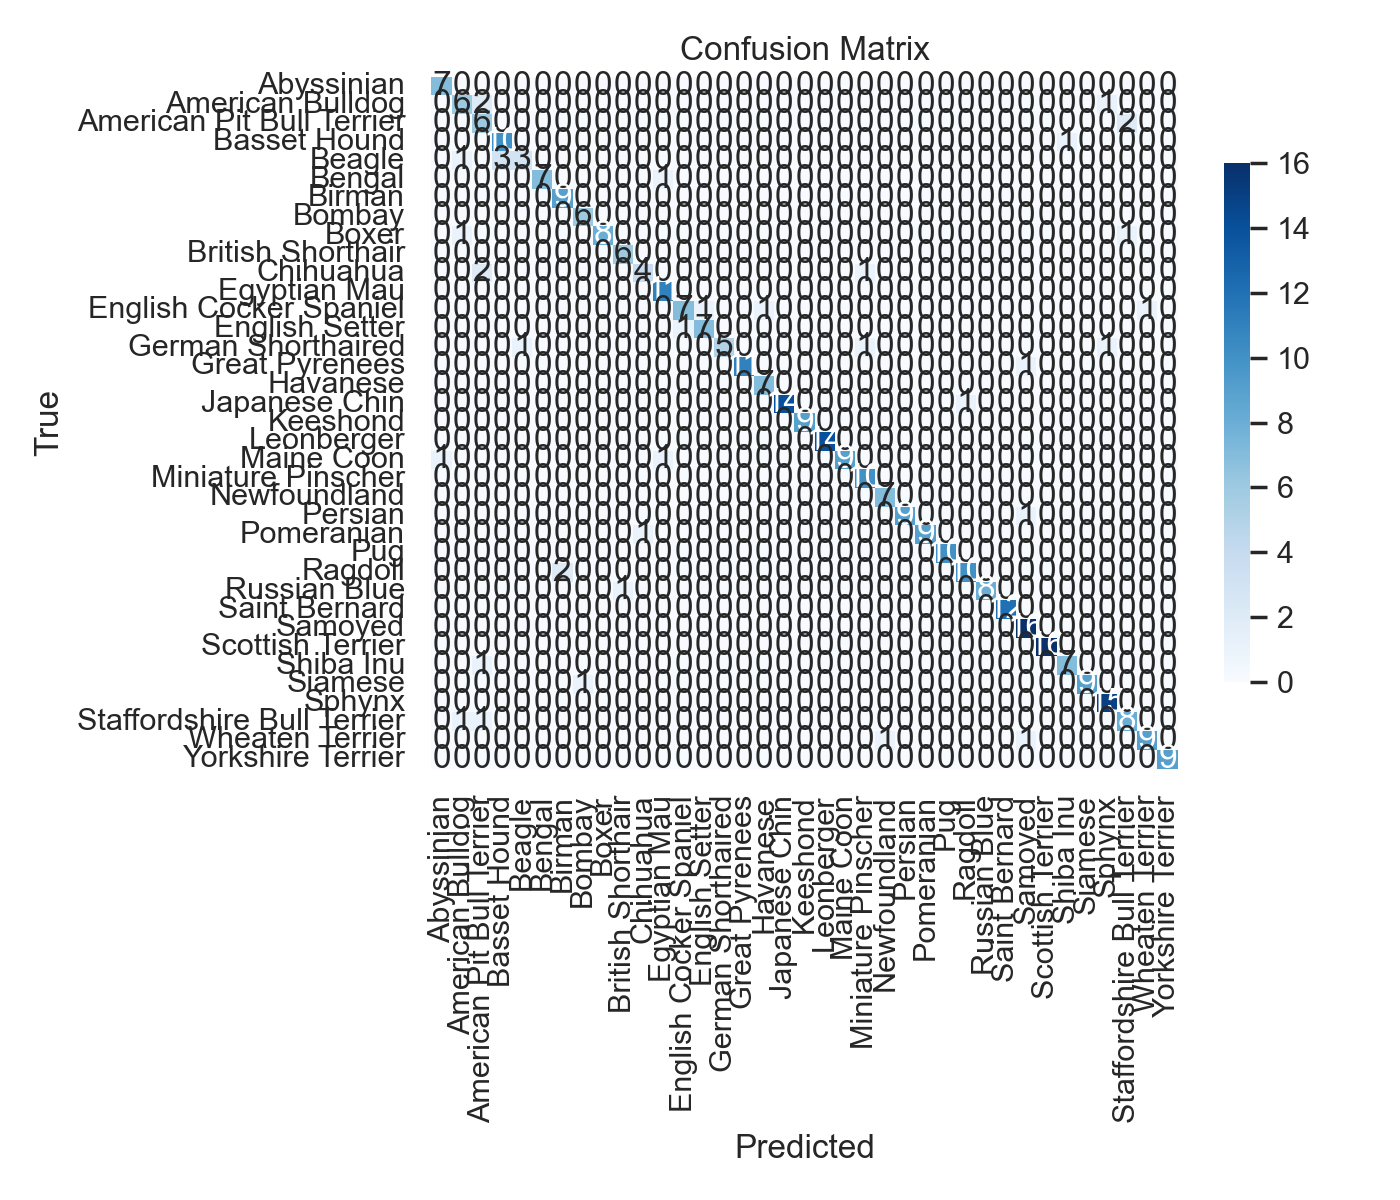

In [11]:
from IPython.display import Image, display

display(Image("outputs/confusion_matrix.png"))


In [12]:
import pandas as pd

per_class = pd.read_csv("outputs/per_class_metrics.csv")
per_class.head()


,Unnamed: 0,precision,recall,f1-score,support
0,Abyssinian,0.8750,1.0000,0.9333,7.0
1,American Bulldog,0.6667,0.6667,0.6667,9.0
2,American Pit Bull Terrier,0.5000,0.7500,0.6000,8.0
3,Basset Hound,0.7692,0.9091,0.8333,11.0
4,Beagle,0.7500,0.4286,0.5455,7.0


### 4.3 Conclusion – Analyse des erreurs

L’analyse de la matrice de confusion et des métriques par classe confirme que le
modèle parvient globalement à bien distinguer les différentes races du dataset
Oxford-IIIT Pet, mais que certaines familles d’animaux restent plus difficiles à reconnaître.

**Points positifs :**

- La diagonale de la matrice de confusion est nettement visible, signe que la
  majorité des classes sont correctement identifiées.
- Certaines races très distinctives (ex. Abyssinian, Basset Hound, Sphynx)
  obtiennent un **recall très élevé (souvent 1.00)** et de bons scores F1.
- Les races à pelage ou morphologie très caractéristiques sont superbement
  reconnues.

**Erreurs récurrentes :**

- Les confusions concernent surtout les **petites races de chiens**
  (Chihuahua, Pomeranian, Miniature Pinscher), qui présentent des silhouettes
  proches et des variations fortes d’angle ou d’échelle dans les images.
- Les **races de chats à pelage clair** (Birman, Ragdoll, Persian) sont parfois
  confondues entre elles, ce qui apparaît clairement dans les valeurs de
  precision / recall plus faibles pour ces classes.
- Certaines images test ont peu de support (5–10 images), ce qui amplifie les
  variations de scores d’une classe à l’autre.

**Tendances globales :**

- Le modèle généralise correctement sur le dataset, mais reste sensible aux
  variations de points de vue, d’éclairage, ou au manque de contraste entre
  races visuellement proches.
- L’accuracy globale d’évaluation (≈ 88.61%) est cohérente avec les résultats
  obtenus en validation, confirmant que le pipeline fonctionne correctement.

En résumé, l’analyse des erreurs montre que les confusions du modèle se
concentrent sur des races visuellement similaires, ce qui est attendu sur ce
type de dataset. Cela ouvre la voie, dans M5, à des pistes d’amélioration
comme l’équilibrage des classes, l’ajout de transformations ciblées ou
l’utilisation d’un backbone plus profond.